# Intro to Scientific Computing

${\bf Problem \,Set\, 5}$

NAME: Brian Tong

DATE: March 17,2016

To hand in your homework, please submit your completed iPython notebook  before 5PM on the last day of Finals: 
${\bf Thursday, \,March\, 17}$

# 1) Stable Fluids

In this problem, we'll make some modifications to the stable fluids code that was constructed during class, and which is available on eCommons. 



The following function "SolveBanded" takes as input an NxN matrix "A" (a numpy array), and a vector "D" (a 1-D array) of length N. The matrix "A" should be in band-diagonal form. It returns the the solution to the matrix problem,
${\bf A} \cdot {\bf x}={\bf D}$,
with the solution x being returned.

The function repacks the input array into a compact form that takes advantage of the fact that the input array is zeros away from the diagonal. It uses the sparse matrix technology provided by scipy's linear algebra packag, "linalg".

In [2]:
from scipy.linalg import solve_banded
from numpy import *
 
def SolveBanded(A, D):
    # Find the diagonals
    ud = insert(diag(A,1), 0, 0) # upper diagonal
    d = diag(A) # main diagonal
    ld = insert(diag(A,-1), len(d)-1, 0) # lower diagonal
 
    # simplified matrix
    ab = matrix([
        ud,
        d,
        ld,
    ])
 
    return solve_banded((1, 1), ab, D )
 

Verify that you can obtain a matrix solution using SolveBanded for the following band-diagonal problem:

In [3]:
A=array([
        [20, -5,  0,  0],
        [-5, 15, -5,  0],
        [ 0, -5, 15, -5],
        [ 0,  0, -5, 10]
        ])
           
B=array([1100, 100, 100, 100])

print SolveBanded(A, B)
print "SolveBanded function works"

[ 64.25531915  37.0212766   26.80851064  23.40425532]
SolveBanded function works


For extra "cred", Using the "SolveBanded" function, replace the explicit solutions to the x- and y- direction velocity and density diffusions with implicit solutions, using the implicit differencing scheme described in class. Verify that the code gives a comparable result for the random density test problem to which it is currently set (run at 50x50 resolution).

Returning to the version of the code on the web, and using 100x100 resolution, set up and run a simulation in which a centrally located circular patch of high-density fluid ($\,\rho=0.75$) is placed in a surrounding region of low-density fluid ($\,\rho=0.25$). (The initial velocity perturbation can remain unchanged). Paste the code block that sets up this initial condition into the cell below:

timestep for velocity diffusion 1000.0
timestep for accurate advection 5.05242836528
initial timestep 5.05242836528


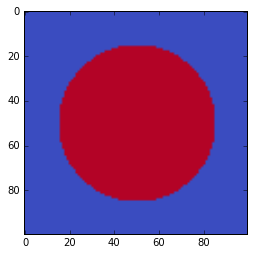

In [104]:
from numpy import *
%matplotlib inline
from matplotlib.pyplot import *
from scipy import ndimage

#define periodic boundary condition
def wrap(x):
    for i in arange(1,nx-1):
        x[i,0]=x[i,ny-2]
        x[i,ny-1]=x[i,1]
    for j in arange(1,ny-1):
        x[0,j]=x[nx-2,j]
        x[nx-1,j]=x[1,j]
    return(x)

#define zero-gradient boundary condition
def zerog(x):
    for i in arange(1,nx-1):
        x[i,0]=x[i,1]
        x[i,ny-1]=x[i,ny-2]
    for j in arange(1,ny-1):
        x[0,j]=x[1,j]
        x[nx-1,j]=x[nx-2,j]
    return(x)

#projection step
def project(vxo,vyo):
    div=ones((nx,ny))

    #compute velocity divergance
    for i in arange(1,nx-1):
        for j in arange(1,ny-1):
            div[i,j]=h*(vxo[i+1,j]-vxo[i-1,j]\
                   +    vyo[i,j+1]-vyo[i,j-1])
        
    #solve Poisson Equation for q using Gauss-Seidel
    q=zeros((nx,ny))
    for k in arange(1,nrelax):
        for i in arange(1,nx-1):
            for j in arange(1,ny-1):
                q[i,j]=0.25*(q[i+1,j]+q[i-1,j]+q[i,j-1]+q[i,j+1]-dx2*div[i,j])
        q=zerog(q)

    #compute gradient of Q
    gradQx=zeros((nx,ny))
    gradQy=zeros((nx,ny))
    for i in arange(1,nx-1):
        for j in arange(1,ny-1):
            gradQx[i,j]=h*(q[i+1,j]-q[i-1,j])  
            gradQy[i,j]=h*(q[i,j+1]-q[i,j-1])
            
    #remove gradient field from the velocity arrays
    vxo=vxo-gradQx
    vyo=vyo-gradQy
    vxo=wrap(vxo)
    vyo=wrap(vyo)
    return(vxo,vyo)

#cell widths and associated variables
global dx
dx=1.
global dy
dy=1.
global h
h=1./(2*dx)
global dx2
dx2=dx*dx
global nx
nx=100 #number of zones in the x-direction
global ny 
ny=100 #number of zones in the y-direction

global nrelax
nrelax=20 #number of relaxation steps for Gauss-Seidel
global nu
nu=0.00025 #diffusion coefficient
global vpf
vpf=0.25 #multiplier for velocity perturbations

#set number of hydrodynamics time steps for the simulation
nsteps=200

#set this up so that we can make a velocity quiver plot to see what's going on with our flow
global x
global y
x, y = mgrid[-ny/2:ny/2:ny*1j, -nx/2:nx/2:nx*1j]
global xg
xg=-nx/2+arange(0,nx)+dx/2
global yg
yg=-ny/2+arange(0,ny)+dy/2


#seed the velocity field with random perturbations
vxo=-vpf/2. + vpf*random.random((nx,ny))
vyo=-vpf/2. + vpf*random.random((nx,ny))

#apply the periodic boundary conditions 
vxo=wrap(vxo)
vyo=wrap(vyo)
vx=zeros((nx,ny))
vy=zeros((nx,ny))

vxo, vyo = project(vxo,vyo)

#density = 0
dno=zeros((nx,ny))

radius = 35
temp = 0
#density at center 
for i in range(len(dno)):
    for j in range(len(dno)):
        temp = sqrt((i-50)**2+(j-50)**2)
        if temp >= radius:
            dno[i][j] = (.25)
        if temp < radius: 
            dno[i][j] = (.75)

dn=zeros((nx,ny))
dno=wrap(dno)

#time-step required for stable velocity diffusion
dt=dx2/(4.*nu)
print 'timestep for velocity diffusion',dt
#calculate the array of speeds
speed=sqrt(vxo**2+vyo**2)
#ensure that timestep is short enough to ensure no more than one zone of advective transport
dtTest=dx/amax(speed)
if dtTest < dt:
    dt=dtTest
    print 'timestep for accurate advection',dt
print 'initial timestep',dt
totalT=0.
imshow(dno, cmap='coolwarm')

step # 0 / 200  Total time elapsed:  5.05242836528
step # 1 / 200  Total time elapsed:  10.1048567306
step # 2 / 200  Total time elapsed:  15.1572850958
step # 3 / 200  Total time elapsed:  19.5711024441
step # 4 / 200  Total time elapsed:  23.0465263223
step # 5 / 200  Total time elapsed:  26.0147387142
step # 6 / 200  Total time elapsed:  28.6378718029
step # 7 / 200  Total time elapsed:  31.0057351003
step # 8 / 200  Total time elapsed:  33.1847864356
step # 9 / 200  Total time elapsed:  35.2217774428
step # 10 / 200  Total time elapsed:  37.1293377839
step # 11 / 200  Total time elapsed:  38.9271991276
step # 12 / 200  Total time elapsed:  40.6181403168
step # 13 / 200  Total time elapsed:  42.217676574
step # 14 / 200  Total time elapsed:  43.7378570163
step # 15 / 200  Total time elapsed:  45.1883099263
step # 16 / 200  Total time elapsed:  46.5769026039
step # 17 / 200  Total time elapsed:  47.9101584514
step # 18 / 200  Total time elapsed:  49.1935776265
step # 19 / 200  Total 

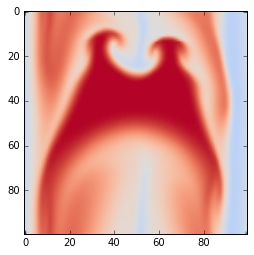

In [105]:
#time loop for the actual simulation:
for k in arange(0,nsteps):
    #define this quantity so we don't continuously recompute it
    dmult=dt*nu/dx2
    for i in arange(1,nx-1):
        for j in arange(1,ny-1):
            vx[i,j]=vx[i,j]-0.05*(dno[i,j]-0.5)*dt
    vxo=wrap(vx)
    vyo=wrap(vy)
    #project
    vxo, vyo = project(vxo,vyo)
            
    #x-direction diffusion update to the x and y velocity components and density tracer
    for i in arange(1,nx-1):
        for j in arange(1,ny-1):
            vx[i,j]=vxo[i,j]+dmult*(vxo[i+1,j]-2*vxo[i,j]+vxo[i-1,j])
            vy[i,j]=vyo[i,j]+dmult*(vyo[i+1,j]-2*vyo[i,j]+vyo[i-1,j])
            dn[i,j]=dno[i,j]+dmult*(dno[i+1,j]-2*dno[i,j]+dno[i-1,j])
    vxo=wrap(vx)
    vyo=wrap(vy) 
    dno=wrap(dn)
    #y-direction diffusion update to the x and y velocity components and density tracer
    for i in arange(1,nx-1):
        for j in arange(1,ny-1):
            vx[i,j]=vxo[i,j]+dmult*(vxo[i,j+1]-2*vxo[i,j]+vxo[i,j-1])
            vy[i,j]=vyo[i,j]+dmult*(vyo[i,j+1]-2*vyo[i,j]+vyo[i,j-1])
            dn[i,j]=dno[i,j]+dmult*(dno[i,j+1]-2*dno[i,j]+dno[i,j-1])
    vxo=wrap(vx)
    vyo=wrap(vy) 
    dno=wrap(dn)
    
    #project
    vxo, vyo = project(vxo,vyo)
    
    #advection update to the velocities
    for i in arange(1,nx-1):
        for j in arange(1,ny-1):
            x1=xg[i]-vxo[i,j]*dt
            y1=yg[j]-vyo[i,j]*dt
            ix=i
            if x1>xg[i]:
                ix=i+1        
            jy=j
            if y1>yg[j]:
                jy=j+1           
            t=(x1-xg[ix-1])/dx
            u=(y1-yg[jy-1])/dy
            vx[i,j]=(1-t)*(1-u)*vxo[ix-1,jy-1]\
                    + t*(1-u)*vxo[ix,jy-1]\
                    + t*u*vxo[ix,jy]\
                    + (1-t)*u*vxo[ix-1,jy]
            vy[i,j]=(1-t)*(1-u)*vyo[ix-1,jy-1]\
                    + t*(1-u)*vyo[ix,jy-1]\
                    + t*u*vyo[ix,jy]\
                    + (1-t)*u*vyo[ix-1,jy]
            dn[i,j]=(1-t)*(1-u)*dno[ix-1,jy-1]\
                    + t*(1-u)*dno[ix,jy-1]\
                    + t*u*dno[ix,jy]\
                    + (1-t)*u*dno[ix-1,jy]
    vxo=wrap(vx)
    vyo=wrap(vy)  
    dno=wrap(dn)
    
    #project again to keep the flow divergance fre
    vxo, vyo = project(vxo,vyo)
    
    #done with velocity update
    totalT=totalT+dt 
    
    #next check for timestep update
    speed=sqrt(vxo**2+vyo**2)
    dtTest=dx/amax(speed)
    if dtTest < dt:
        dt=dtTest
        
    print 'step #',k,'/',nsteps,' Total time elapsed: ',totalT
    
    #density plot code
    imshow(dno, cmap='coolwarm')
    
    

#2) Using a multi-parameter optimization to find a planet 

In class, we outlined the problem of using an optimization algorithm to determine the best orbital model for a given radial velocity data set. Now, we'll put theory into practice.

The data that we'll use was obtained with the Automated Planet Finder (APF) telescope on Mt. Hamilton, and is on eCommons under the name HD217014_APF. We'll use the 2-dimensional Simplex method to find the Time of Periastron and the Mass of the planet, given its orbital period.

The radial velocity data file consists of a number of columns. Only the first three columns are important. The first column gives the time of the observation of the star in Julian days. (The Julian day count started on November 24, 4714 BCE according to our current Gregorian calendar, and each new Julian day starts at Noon, Greenwich Mean Time). I would advise subtracting off the time of the first observation from all subsequent observations. This start time, T=0 defines your initial "epoch", and you can see when it was using the Julian Date Converter of the US Naval Observatory:

http://aa.usno.navy.mil/data/docs/JulianDate.php

What was the calendar date of the first observation, which we're now defining as $t=0$?

In [271]:
#Populate the data into these empty list objects
global time
global rVelocity
global uncertainty
time = []
rVelocity = []
uncertainty = []

#open text file and read the lines
f = open('HD217014_APF.vels.txt', 'r')
f.seek(0)
for line in f:
    spl=line.split()
    time.append(spl[0])
    rVelocity.append(spl[1])
    uncertainty.append(spl[2])
    
#define varibles
time = array(time).astype(float)
rVelocity = array(rVelocity).astype(float)
uncertainty = array(uncertainty).astype(float)

print time[0]
temp = time[0]
#subtract every varibles (t>0) by t=0
for i in range(len(time)):
    time[i] = time[i] - temp
print "2013 June 29 07:44:41 is define as t = 0"

2456472.8227
2013 June 29 07:44:41 is define as t = 0


The second column gives the observed radial velocity measurement for the star, $v_{obs_{i}}$ in m/s, and the third column gives $\sigma_i$, the measurement uncertainty. You should read in these three needed columns and convert everything to cgs units:


In [272]:
rVelocity = rVelocity*100 #cm/s
uncertainty = uncertainty *100 #cm/s

The planet and the star are both orbiting around their mutual center of mass. The radial velocity curve of the star is a function of the orbital parameters of the planet, as well as the masses of both the planet and the star. In order to make things relatively simple, we'll make a few assumptions. First, as we showed in class using the *Systemic Console* (online version is here, http://www.stefanom.org/systemic-live/, check it out), the period of the planet is $P=4.231$ days. We'll also assume that the planet has a circular orbit, and that its inclination to the sky plane is 90 degrees (that is, that we're seeing the star-planet system edge on), and that the mass of the parent star is one solar mass, ($M_{\star}=M_{\odot}$). With these assumptions, the radial velocity of the star, $V_{\star}$ at a given moment in time, $t$, is 

$$V_{\star}(t)=K \cos (\theta)$$

where $K$ is the amplitude of the star's sinusoidal velocity curve,

$$K=\left(\frac{2\pi G}{P}\right)^{1/3}\frac{M_{\rm pl}}{{M_{\odot}}^{2/3}}$$

and the angle $\theta$ is the *mean anomaly* of the planet at the time that the planet was observed (one often sees the letter $M$ used for mean anomaly, but this seems confusing given that we're using $M$s already for the masses. The mean anomaly is related to the time, $T_{\rm peri}$ that the planet goes through its periastron passage.

$$\theta=\frac{2\pi}{P}(t-T_{\rm peri})$$

For a circular orbit, the time of periastron passage is defined as the moment when the planet is headed directly toward the Earth:

<img src="RVschematic.png" style="width: 400px;"/>

To fix ideas, we'll assume that the first observation takes place at time $t=0$, and that $T_{\rm peri}$ was the time of the last periastron passage that took place *before* $t=0$. This means that the $T_{\rm peri}$ could have potentially occurred anywhere between $T_{\rm peri}=-P=-4.231$ days and $T_{\rm peri}=0$ days before the $t=0$ time. Of course if we're using cgs units, our unit of time will be seconds, not days. There are 86,400 seconds in a Julian day -- same as the number in a regular day.

In order to make a radial velocity curve, we therefore need to specify *two* unknown quantities: (1) $T_{\rm peri}$, the time of periastron passage, and (2) $M_{\rm pl}$, the mass of the planet. Let's assume that the planet can range anywhere from zero Jupiter masses to 10 Jupiter masses (expressed in grams, since we're using cgs).


Based on the above description, write a function that takes a Time of periastron, $T_{\rm peri}$, a planetary mass, $M_{\rm pl}$, and a time $t$ as input and returns the radial velocity, $V_{\star}(t)$ of the star.

In [273]:
global au
au = 1.49e13 #cm
global G
G = 6.67e-8 #cm3 g^-1 s^-2
global mSun
mSun = 1.989e33 #g
global MJupiter
mJupiter = (0.0009543 *mSun) #g 
global day
day = 86400 #s
global period
period = 4.231 *day #s

def radVelocity(Tperi,Mpl,t):
    theta = (2*pi* (t - Tperi))/period 
    k = ((2.*pi*G)/period)**(1./3.)*Mpl/mSun**(2./3.)
    V= k*cos(theta)
    return V

What is the radial velocity of the star if $T_{peri}=-1.33$ days, $M_{\rm pl}=2.37\,M_{\rm Jup}$, and $t=2\,$d?

In [274]:
Tperi = -1.33 * day 
Mpl = 2.37 * mJupiter
t = 2 *day

print radVelocity(Tperi, Mpl, t) ,"cm/s"

6867.1467899 cm/s


Next, given a choice for the planet mass and the time of periastron, we need to compute the radial velocity that the star would have at each moment it was observed, and we need to see how well the radial velocities from this "model" (i.e. choice of $T_{\rm peri}$ and $M_{\rm pl}$) fits the data. Write a function that returns the goodness of fit $\chi^{2}$ for a particular choice of $T_{\rm peri}$ and $M_{\rm pl}$, given the times, velocities and uncertainties of the observations:

$$\chi^{2}=\sum_{i=1}^{N_{\rm obs}}\left[\frac{v_{obs_{i}}-V_{\star}(t_i)}{\sigma_{i}}\right]^{2}\, .$$

In [275]:
def gof(Tperi, Mpl):
    xx = []
    for i in range(len(time)):
        temp = ((rVelocity[i] - radVelocity(Tperi, Mpl, time[i]))/uncertainty[i])**2
        xx.append(temp)
    xx = array(xx).astype(float)
    return sum(xx)

What is the radial velocity of the star if $T_{peri}=-1.33$ days and $M_{\rm pl}=2.37\,M_{\rm Jup}$?

In [276]:
print gof(Tperi, Mpl)

849664.399539


In class, we described the use of the "downhill simplex" optimization technique to find the best fit for the planet mass and time of periastron passage. Ideally, it would be good to use this method to find the best fit, but I realize that this is a lot of work. So let's do a simpler "brute force" optimization technique. Let's divide the range of possible masses into 50 equal increments and the range of possible $T_{\rm peri}$ into 50 equal increments. Test all these possibilities to find which pair gives the lowest value for $\chi^{2}$

In [278]:
Mpl = arange(0*mJupiter, 10 *mJupiter, .2*mJupiter)
Tperi = arange(-period, 0 , period/50.)
countI = 0
countJ = 0
ii = 0
jj = 0
temp2 = 1000000000
mintemp = []
for i in range(len(Mpl)):
    for j in range(len(Mpl)):
        temp3 = gof(Tperi[i], Mpl[j])
        mintemp.append(temp3)
        if temp3 < temp2:
            ii = i 
            jj = j
            temp2 = temp3
            
print min(mintemp), "is the lowest value for chi^2"
print "At", Tperi[ii], "s and", Mpl[jj],"g"

73820.0893971 is the lowest value for chi^2
At -270513.216 s and 3.7962054e+29 g
